# 음향 데이터
- 월간 데이콘 음향 데이터 COVID-19 검출 AI 경진대회
- https://dacon.io/competitions/official/235910/overview/description

#### 참조
- https://jerimo.github.io/python/mfcc/

### 목차
1. 데이터 전처리 (wav file -> DataFrame)
2. 표준화 및 라벨링 작업
3. 모델링 작업 반복
4. 예측

## 1. 데이터 전처리(wav file -> DataFrame)

In [3]:
import librosa

In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16
from keras.utils import plot_model # 모델 플롯 그리기
from keras.utils import set_random_seed # 랜덤 시드 설정
from keras.models import save_model, load_model # 모델 저장 및 로드

In [7]:
set_random_seed(42)

In [27]:
PATH = r'C:\Users\User\Downloads\open'
train_data = pd.read_csv(PATH+'\\train_data.csv')
test_data = pd.read_csv(PATH+'\\test_data.csv' )
print(train_data["covid19"].value_counts())
print(train_data.info())

0    3499
1     306
Name: covid19, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3805 entries, 0 to 3804
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     3805 non-null   int64 
 1   age                    3805 non-null   int64 
 2   gender                 3805 non-null   object
 3   respiratory_condition  3805 non-null   int64 
 4   fever_or_muscle_pain   3805 non-null   int64 
 5   covid19                3805 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 178.5+ KB
None


In [28]:
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5732 entries, 0 to 5731
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     5732 non-null   int64 
 1   age                    5732 non-null   int64 
 2   gender                 5732 non-null   object
 3   respiratory_condition  5732 non-null   int64 
 4   fever_or_muscle_pain   5732 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 224.0+ KB
None


In [30]:
import os
os.listdir(PATH+"\\train")[:10]

['00001.wav',
 '00002.wav',
 '00003.wav',
 '00004.wav',
 '00005.wav',
 '00006.wav',
 '00007.wav',
 '00008.wav',
 '00009.wav',
 '00010.wav']

### 이미지 그려보기

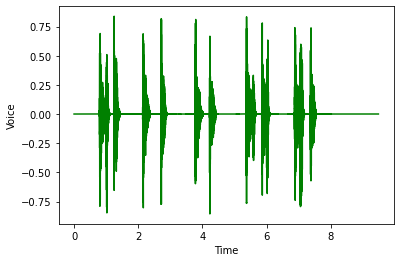

In [49]:
def voice(FILENAME):
    signal, sr = librosa.load(FILENAME, sr=16000)
    time = np.linspace(0, len(signal)/16000 , len(signal))
    fig, ax = plt.subplots()
    ax.plot(time, signal, color='g')
    ax.set_xlabel("Time")
    ax.set_ylabel("Voice")
    plt.show()

voice(r"C:\Users\User\Downloads\open\train\00003.wav")

In [60]:
# signal, sr = librosa.load(r"C:\Users\User\Downloads\open\train\00003.wav", sr=16000)
# mfccs = librosa.feature.mfcc(signal, sr =sr, n_mfcc=20)
# #visualize mfccs
# plt.figure(figsize=(25,10))
# librosa.display.specshow(mfccs, x_axis='Time', sr=sr)
# plt.colorbar(format="%+2f")
# plt.show()

### librosa.feature.mfcc의 파라미터 설명
|파라미터|디폴트|설명|
|------|---|---|
|sr|22050|wav파일은 sr=16000으로 고정|
|n_mfcc|20|특징벡터의 개수 결정|
|n_fft|2048|음성의 길이를 얼만큼 자를지 결정하는 파라미터, n_fft = 0.025*sr|
|hop_length|512|길이만큼 데이터를 읽음, hop_length = 0.01*sr|
|S|None|log-power Mel spectrogram|
|dct_type|2|{1,2,3} 중 선택|

In [69]:
# wav파일의 PATH가 주어졌을 때, librosa로 데이터 로딩
import os
def wav_to_df(foldername, df):
    y_mean = []; count = 0
    PATH = r'C:\Users\User\Downloads\open'
    ab_path = PATH+f"\\{foldername}"
    filelist = os.listdir(ab_path)
    for filename in filelist:
        signal, sr = librosa.load(ab_path + f"\\{filename}" ,sr=16000)
        # sr은 16000으로 고정, n_mfcc는 변동
        sound_mfcc = librosa.feature.mfcc(signal, sr, n_mfcc=20, n_fft=400,hop_length=160)
        x_mean = [np.mean(val) for val in sound_mfcc]
        y_mean.append(x_mean)
        count += 1
        print(round(100 * count/len(filelist)))
    data = pd.DataFrame(y_mean, columns=['mfcc_' + str(i) for i in range(1, 21)])   # range 끝점은 n_mfcc + 1
    df = pd.concat([df, data], axis=1)
    df.to_csv(f"{foldername}_mfcc.csv", index=False)
    return df

In [ ]:
wav_to_df("train",train_data)

In [70]:
import warnings
warnings.filterwarnings(action='ignore')
wav_to_df("test",test_data)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9


,id,age,gender,respiratory_condition,fever_or_muscle_pain,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20
0,3806,48,female,1,0,-716.935364,6.853111,0.763934,1.694794,0.079593,...,-1.216279,0.466157,-0.608201,-0.202258,0.001240,-0.648526,-0.523684,-0.090677,-0.753035,0.072157
1,3807,24,female,0,0,-627.925903,6.017004,-2.627550,-2.025275,-2.589574,...,-1.040553,3.068777,-2.579927,0.042124,-0.615300,0.322384,-2.085197,0.960038,-1.132387,0.400113
2,3808,29,male,0,0,-1131.210449,0.109457,0.019841,-0.018897,-0.073077,...,-0.037995,-0.074990,-0.101946,-0.030108,0.027890,0.035572,0.035881,-0.026483,-0.036079,-0.008071
3,3809,39,female,0,0,-539.687866,26.747046,-8.997430,10.515906,-0.327795,...,-13.205245,0.504863,-4.429300,-4.769868,-6.190238,-0.297510,-6.995588,-4.735684,-0.124145,-1.835923
4,3810,34,male,0,0,-550.211304,36.625832,-12.274111,-4.107415,-6.481833,...,-3.412825,1.475812,-4.737418,3.900885,-2.967060,-6.202752,-3.629142,1.882961,-6.869742,2.566553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5727,9533,43,male,0,0,-533.494934,41.932346,7.920476,11.043939,-6.812698,...,-3.064833,-6.442965,-12.794773,-3.514174,-4.452114,-1.010820,-1.165020,0.621052,-5.520166,-3.379230
5728,9534,48,female,0,1,-767.290222,1.483402,0.924588,4.351909,-3.511944,...,-3.026947,1.570185,-2.570442,0.049423,-1.432849,0.766279,-0.705677,0.135066,-0.627184,-1.073901
5729,9535,44,female,0,0,-511.768219,42.444366,-14.177906,11.562706,-4.603049,...,-5.770044,2.601554,-6.501681,-2.633171,-0.425087,-0.581886,-5.583819,-1.333742,-3.303022,-2.073881
5730,9536,25,female,0,0,-674.009033,12.818462,-7.823106,4.066099,-5.669241,...,-2.404568,-1.935951,-3.116379,-3.648706,-2.824821,-2.211466,-0.128513,0.158447,1.745161,0.638750


## 2. 표준화 및 라벨링 작업

In [154]:
train_df = pd.read_csv('train_mfcc.csv', index_col=0)
test_df = pd.read_csv('test_mfcc.csv', index_col=0)
col = list(range(len(train_df.columns)))
col.remove(4)
train_data = train_df.iloc[:,col]
train_target = train_df.iloc[:,4]

In [155]:
print(train_data.shape, train_target.shape, test_df.shape)

(3805, 24) (3805,) (5732, 24)


In [156]:
# 라벨 인코딩
lb = LabelEncoder()
lb.fit(train_data['gender'])
train_data['gender'] = lb.transform(train_data['gender'])
test_df['gender'] = lb.transform(test_df['gender'])

In [157]:
# 표준화
st = StandardScaler()
st.fit(train_data)
train_scaled = st.transform(train_data)
test_scaled = st.transform(test_df)

In [106]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.95)
# pca.fit(train_scaled)
# train_scaled = pca.transform(train_scaled)
# test_scaled = pca.transform(test_scaled)

In [110]:
# train_scaled = pca.inverse_transform(train_scaled)
# test_scaled = pca.inverse_transform(test_scaled)

In [111]:
print(train_scaled.shape, test_scaled.shape)

(3805, 24) (5732, 24)


## 3. 모델링 작업 반복
- 3-1. DNN
- 3-2. CNN
- 3-3. RandomForest
- 3-4. MGP ..

In [158]:
dnn = Sequential()
dnn.add(Dense(32, input_shape=(24,), activation='relu'))
dnn.add(Dropout(0.3))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dropout(0.3))
dnn.add(Dense(2, activation='sigmoid'))
dnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 32)                800       
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                1056      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 2)                 66        
                                                                 
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________


In [159]:
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, stratify=train_target)

In [138]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [160]:
dnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics= ['accuracy',f1_m,precision_m, recall_m])
history = dnn.fit(train_scaled, train_target, validation_data=(val_scaled, val_target), epochs=50)
loss, accuracy, f1_score, precision, recall = dnn.evaluate(train_scaled, train_target)

Epoch 1/50
96/96 [==============================] - 1s 4ms/step - loss: 0.3796 - accuracy: 0.8962 - f1_m: 0.1477 - precision_m: 0.0813 - recall_m: 1.0467 - val_loss: 0.3020 - val_accuracy: 0.9198 - val_f1_m: 0.1389 - val_precision_m: 0.0763 - val_recall_m: 0.9167
Epoch 2/50
96/96 [==============================] - 0s 2ms/step - loss: 0.3134 - accuracy: 0.9195 - f1_m: 0.1463 - precision_m: 0.0801 - recall_m: 1.0802 - val_loss: 0.2771 - val_accuracy: 0.9198 - val_f1_m: 0.1387 - val_precision_m: 0.0762 - val_recall_m: 0.9167
Epoch 3/50
96/96 [==============================] - 0s 2ms/step - loss: 0.2987 - accuracy: 0.9192 - f1_m: 0.1501 - precision_m: 0.0826 - recall_m: 1.0457 - val_loss: 0.2715 - val_accuracy: 0.9198 - val_f1_m: 0.1405 - val_precision_m: 0.0772 - val_recall_m: 0.9167
Epoch 4/50
96/96 [==============================] - 0s 2ms/step - loss: 0.2951 - accuracy: 0.9202 - f1_m: 0.1502 - precision_m: 0.0819 - recall_m: 1.1062 - val_loss: 0.2636 - val_accuracy: 0.9198 - val_f1_m: 

In [125]:
y_pred = dnn.predict(val_scaled)
for i in y_pred:
    print(i)

24/24 [==============================] - 0s 2ms/step
[0.75416005 0.24494588]
[0.9137849  0.24067338]
[0.64811474 0.35451376]
[0.74502647 0.27495104]
[0.8004371  0.28043264]
[0.7695647  0.33271056]
[0.82623243 0.21402615]
[0.7724817  0.28793567]
[0.7665888 0.2913723]
[0.6808073  0.34651962]
[0.74869865 0.3295347 ]
[0.766283   0.34543434]
[0.7132931 0.3137323]
[0.91402805 0.25351486]
[0.81988996 0.25428873]
[0.6973368 0.3137863]
[0.7334855  0.32506293]
[0.78199714 0.26762587]
[0.8606472  0.25931823]
[0.8234775  0.23705305]
[0.72821945 0.32379046]
[0.73100543 0.28032714]
[0.7834318  0.30565733]
[0.7650042  0.27989116]
[0.7280505 0.3467633]
[0.6778515 0.257532 ]
[0.6688774  0.35964966]
[0.9230891  0.16756213]
[0.8194538 0.2880951]
[0.6931241 0.332386 ]
[0.7285138  0.31563327]
[0.79209226 0.25149167]
[0.72953796 0.3100842 ]
[0.87561494 0.1834238 ]
[0.7389032  0.29499942]
[0.76224154 0.32054657]
[0.82606167 0.22105964]
[0.90054077 0.18194611]
[0.76799583 0.25681758]
[0.72217304 0.2585306 ]
[

In [147]:
# 3-3. RandomForest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(train_scaled, train_target)
print(rfc.score(train_scaled, train_target))
print(rfc.score(val_scaled, val_target))


1.0
0.9185282522996058


In [153]:
from lightgbm import L

6.318770139085559

In [149]:
y_pred = rfc.predict(val_scaled)

In [151]:
print(classification_report(val_target, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       700
           1       0.00      0.00      0.00        61

    accuracy                           0.92       761
   macro avg       0.46      0.50      0.48       761
weighted avg       0.85      0.92      0.88       761



## 4. 예측